In [ ]:
!pip install prophet

In [ ]:
!pip install --upgrade pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
                             r2_score, accuracy_score, classification_report, confusion_matrix)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.stats import shapiro
import prophet
from pmdarima import auto_arima
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot, plot_cross_validation_metric
import warnings
import logging

In [ ]:
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [ ]:
def check_versions():
  print(f'Pandas версия: {pd.__version__}')
  print(f'Numpy версия: {np.__version__}')
  print(f'Matplotlib версия: {plt.matplotlib.__version__}')
  print(f'Seaborn версия: {sns.__version__}')
  print(f'Scikit-learn версия: {sklearn.__version__}')
  print(f'Tensorflow версия: {tf.__version__}')
  print(f'Statsmodels версия: {sm.__version__}')
  print(f'Prophet версия: {prophet.__version__}')
  print(f'Библиотеки успешно импортированы.')

check_versions()

Pandas версия: 2.1.4
Numpy версия: 1.26.4
Matplotlib версия: 3.7.1
Seaborn версия: 0.13.1
Scikit-learn версия: 1.3.2
Tensorflow версия: 2.17.0
Statsmodels версия: 0.14.2
Prophet версия: 1.1.5
Библиотеки успешно импортированы.


In [ ]:
def load_and_prepare_data(file_path):
  """
  Загружает и подготавливает данные из CSV файла.

  Аргументы:
  file_path : str
      Путь к CSV файлу с данными.

  Возвращает:
  pandas.DataFrame
      Подготовленный датафрейм с данными, где:
    - Удалены пробелы из названий столбцов.
    - Столбец 'year' преобразован в формат даты и установлен в качестве индекса.
    - Все числовые столбцы преобразованы в тип float.
    - Данные отсортированы по году.
  """
  df = pd.read_csv(file_path, delimiter=';')
  df.columns = df.columns.str.strip()
  df['year'] = pd.to_datetime(df['year'], format='%Y') + pd.offsets.YearEnd(0)
  numeric_columns = df.columns[1:]
  df[numeric_columns] = df[numeric_columns].astype(float)
  df.sort_values('year', inplace=True)
  df.set_index('year', inplace=True)
  return df

df = load_and_prepare_data('/content/Data_new.csv')

In [ ]:
df.head()

,zan(cfo),zan(szfo),zan(ufo),zan(skfo),zan(pfo),zan(uralfo),zan(sfo),zan(dfo),bezr(cfo),bezr(szfo),...,bezr(sfo),bezr(dfo),srd(cfo),srd(szfo),srd(ufo),srd(skfo),srd(pfo),srd(uralfo),srd(sfo),srd(dfo)
year,,,,,,,,,,,,,,,,,,,,,
2000-12-31,18014.45,6684.28,5850.76,2603.97,14242.84,5720.02,7933.75,4020.35,1516.38,710.35,...,1124.00,628.32,3231.0,2269.0,1592.0,1130.0,1726.0,2744.0,1933.0,2498.0
2001-12-31,18209.86,6788.93,5846.68,2653.35,14225.29,5642.28,7817.38,3939.14,1165.34,556.96,...,929.68,521.56,4300.0,3084.0,2165.0,1441.0,2319.0,3820.0,2576.0,3304.0
2002-12-31,18596.99,6911.31,6071.07,2762.83,14457.40,5733.71,8054.44,4071.13,1000.25,460.45,...,868.63,435.51,5436.0,4010.0,2898.0,1922.0,3035.0,4791.0,3373.0,4391.0
2003-12-31,18609.92,6873.34,5816.19,2765.72,14280.29,5974.66,7972.59,4046.69,1002.11,516.25,...,972.79,455.21,7211.0,5403.0,3747.0,2532.0,3917.0,6110.0,4351.0,5788.0
2004-12-31,18912.54,6970.38,6156.19,2769.92,14378.12,5938.58,8179.20,4013.68,930.45,443.38,...,853.29,442.81,8992.0,6938.0,4565.0,3466.0,4787.0,7413.0,5267.0,7047.0


In [ ]:
def plot_time_series(data, filter_str, title, ylabel):
  """
  Строит график временного ряда на основе переданных данных.

  Аргументы:
  data : pandas.DataFrame
      Датафрейм с данными для построения графика.
  filter_str : str
      Подстрока для фильтрации колонок в датафрейме.
  title : str
      Заголовок графика.
  ylabel : str
      Название оси Y.

  Возвращает:
  None
      Функция отображает график временного ряда и не возвращает значения.
  """
  sns.set(style='whitegrid')
  sns.set_palette('pastel')
  plt.figure(figsize=(12, 8))
  sns.lineplot(data=data.filter(like=filter_str), markers=True)
  plt.title(title, fontsize=16)
  plt.xlabel('Год', fontsize=14)
  plt.ylabel(ylabel, fontsize=14)
  plt.legend(title='Округа', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(True)
  plt.show()

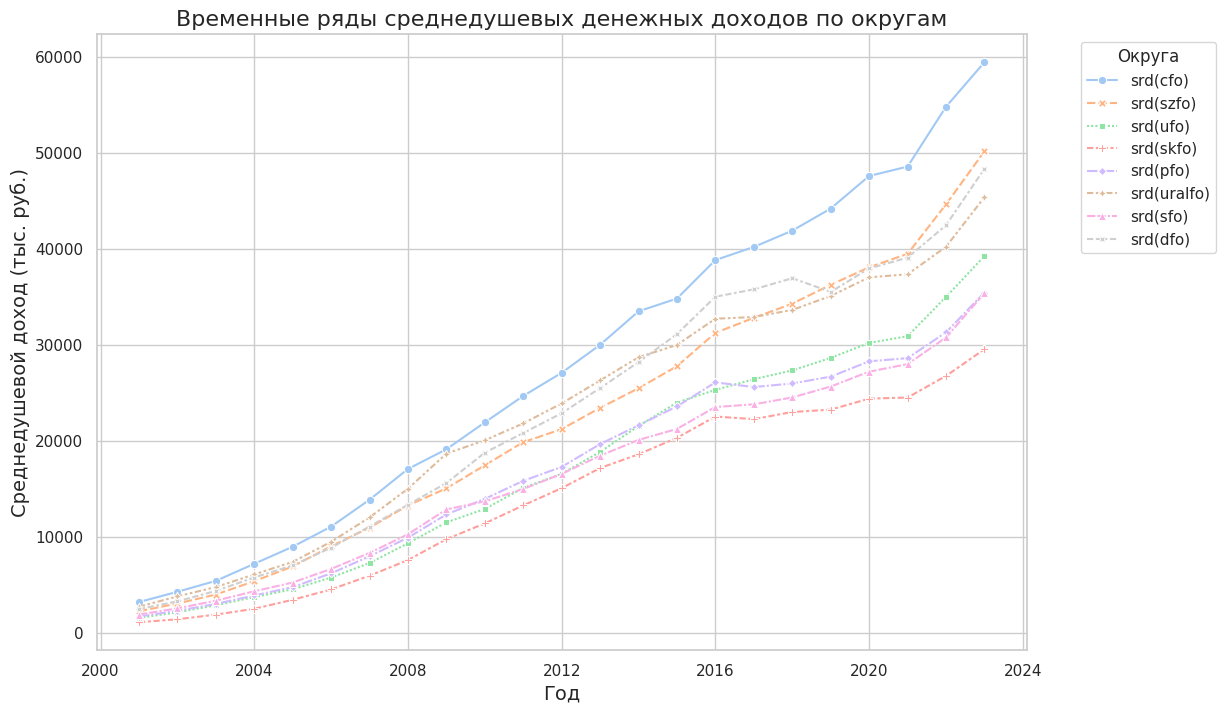

In [ ]:
plot_time_series(df, 'srd',
                 'Временные ряды среднедушевых денежных доходов по округам',
                 'Среднедушевой доход (тыс. руб.)')

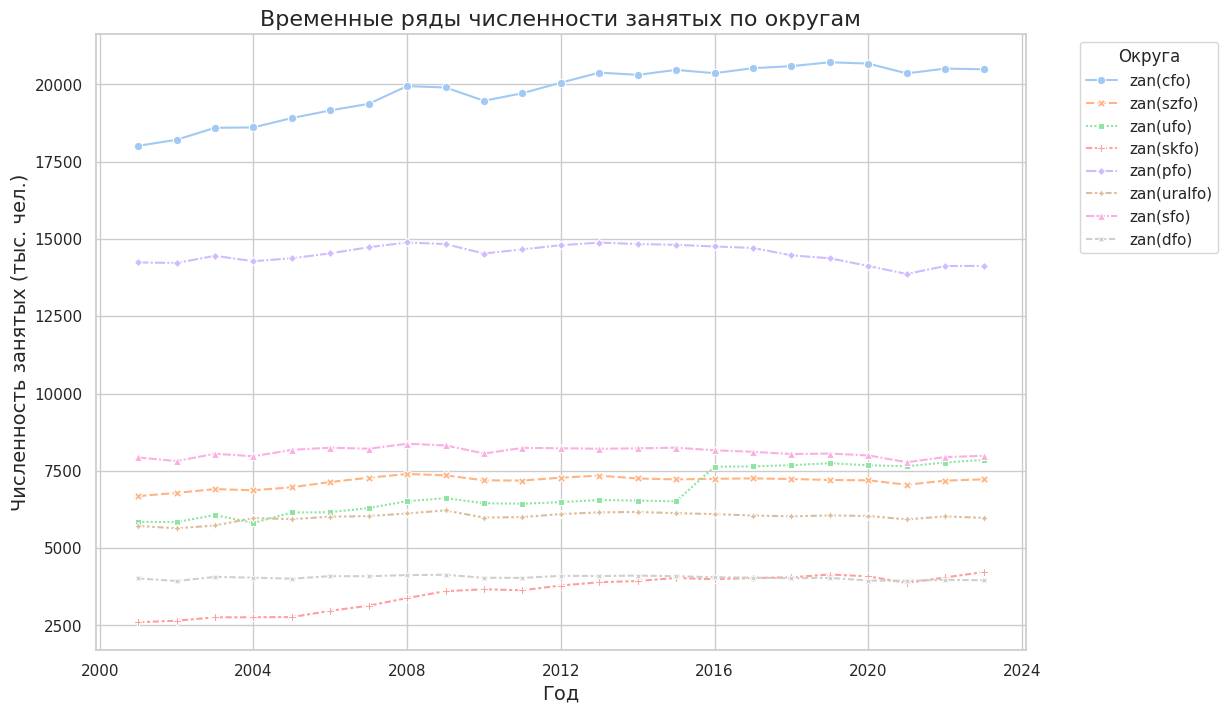

In [ ]:
plot_time_series(df, 'zan',
                 'Временные ряды численности занятых по округам',
                 'Численность занятых (тыс. чел.)')

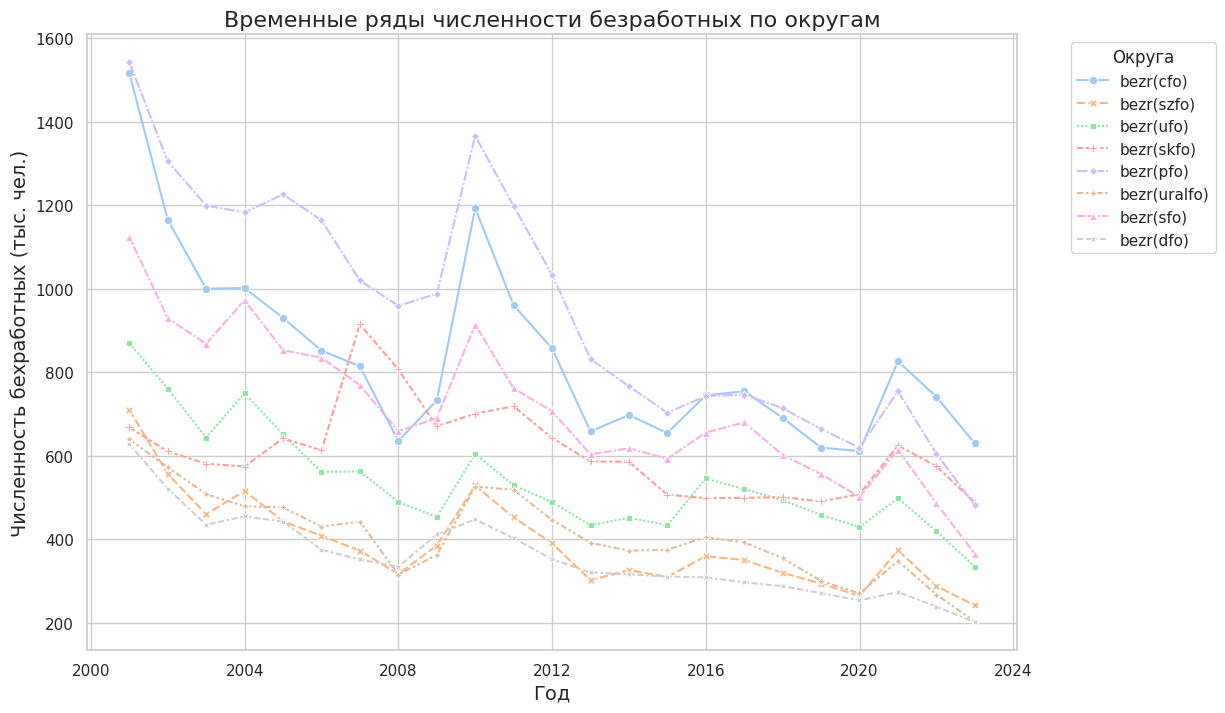

In [ ]:
plot_time_series(df, 'bezr',
                 'Временные ряды численности безработных по округам',
                 'Численность бехработных (тыс. чел.)')

In [ ]:
def analyze_variable(data, column_name):
  """
  Анализирует и визуализирует временной ряд для указанной переменной.

  Аргументы:
  data : pandas.DataFrame
      Датафрейм с данными.
  column_name : str
      Название переменной(столбца) для анализа.

  Возвращает:
  None
      Функция выводит статистику переменной и отображает график временного
      ряда, не возвращая значений.
  """
  data = df.loc[:, [column_name]]
  stats = data.describe()

  # Вывод статистики
  print(f'статистика для переменной {column_name}')
  print(stats)

  # Визуализация временного ряда
  plt.figure(figsize=(12, 6))
  sns.lineplot(x=data.index, y=column_name, data=data, marker='o', label=column_name)
  plt.title(f'Временной ряд переменной {column_name}')
  plt.xlabel('Год')
  plt.ylabel(column_name)
  plt.legend()
  plt.grid(True)
  plt.show()

статистика для переменной zan(ufo)
          zan(ufo)
count    23.000000
mean   6782.708696
std     728.793538
min    5816.190000
25%    6231.690000
50%    6520.040000
75%    7647.220000
max    7855.220000


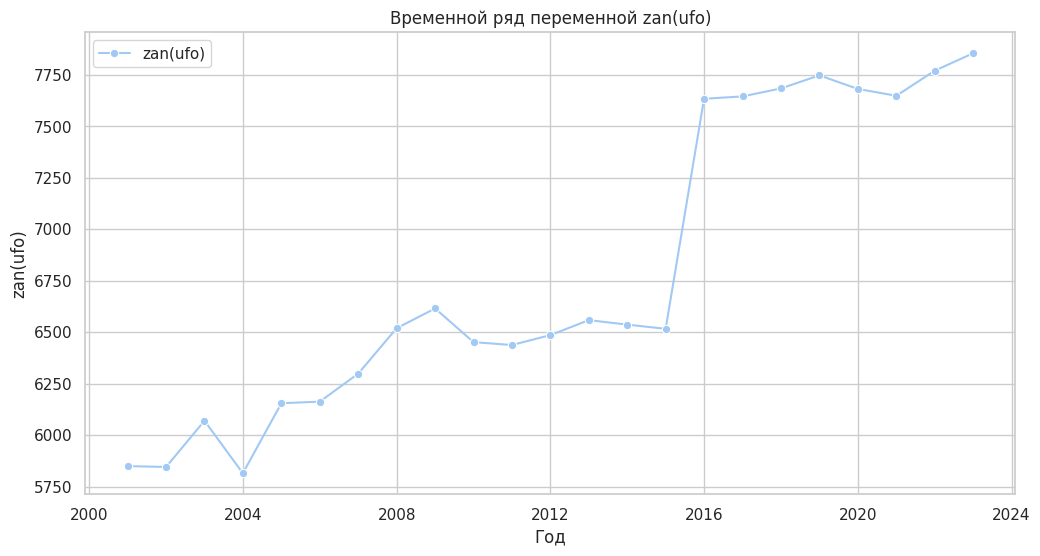

In [ ]:
analyze_variable(df,'zan(ufo)')

In [ ]:
'''def test_stationarity(data, variable_name):
  """
  Проводит тест на стационарность временного ряда.

  Аргументы:
  data : pandas.DataFrame
      Датафрейм с данными.
  column_name : str
      Название переменной(столбца) для анализа.

  Возвращает:
  bool
      True, если ряд стационарен, иначе False.
  """
  result = adfuller(df[variable_name], autolag='AIC')
  print('ADF Statistic:', result[0])
  print('p-value:', result[1])
  print('Critical Values:', result[4])

  is_stationary = result[1] <= 0.05
  if is_stationary:
    print('Ряд стационарен(отклоняем нулевую гипотезу)')
  else:
    print('Ряд не стационарен(не отклоняем нулевую гипотезу)')

  return is_stationary'''

In [ ]:
test_stationarity(df, 'zan(ufo)')

ADF Statistic: -0.6666165850793557
p-value: 0.855208167276144
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
Ряд не стационарен(не отклоняем нулевую гипотезу)


False

In [ ]:
'''def difference_for_stationarity(data, variable_name, max_diff=5):
  """
  Проводит дифференциацию временного ряда для приведения его
  к стационарному виду и повторый тест на стационраность

  Аргументы:
  data : pandas.DataFrame
      Датафрейм с данными.
  column_name : str
      Название переменной(столбца) для которой выполняется дифференциация.

  Возвращает:
  pandas.DataFrame or None
      Новый датафрейм с дифференцированными переменными или None, если ряд
      стационарен.
  """
# Извлекаем временной ряд для указанной переменной
  time_series = data[variable_name]

  def adf_test(series):
      """Проводит тест ADF и возвращает, является ли ряд стационарным."""
      result = adfuller(series, autolag='AIC')
      print('ADF Statistic:', result[0])
      print('p-value:', result[1])
      print('Critical Values:', result[4])
      return result[1] <= 0.05

  # Проверка на стационарность исходного ряда
  if adf_test(time_series):
      print("Исходный ряд уже стационарен. Дифференциация не требуется.")
      return None

  num_diff = 0
  df_diff = pd.DataFrame()

  # Проводим дифференциацию до достижения стационарности или до достижения max_diff
  while not adf_test(time_series):
      if num_diff >= max_diff:
          print(f"Превышено максимальное количество дифференциаций ({max_diff}). Ряд все еще не стационарен.")
          break

      # Дифференцируем временной ряд
      time_series = time_series.diff().dropna()
      num_diff += 1
      variable_name_diff = f'{variable_name}_diff_{num_diff}'
      df_diff[variable_name_diff] = time_series

      print(f"Дифференциация {num_diff}: p-value после дифференциации: {adfuller(time_series, autolag='AIC')[1]}")

  # Визуализация дифференцированного ряда
  if not df_diff.empty:
      plt.figure(figsize=(12, 6))
      plt.plot(time_series)
      plt.title(f'Дифференцированный ряд {variable_name} (после {num_diff} дифференциаций)')
      plt.show()

  return df_diff if not df_diff.empty else None'''

ADF Statistic: -0.6666165850793557
p-value: 0.855208167276144
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: -0.6666165850793557
p-value: 0.855208167276144
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
Дифференциация 1: p-value после дифференциации: 4.173675143405018e-06
ADF Statistic: -5.356699514904001
p-value: 4.173675143405018e-06
Critical Values: {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}


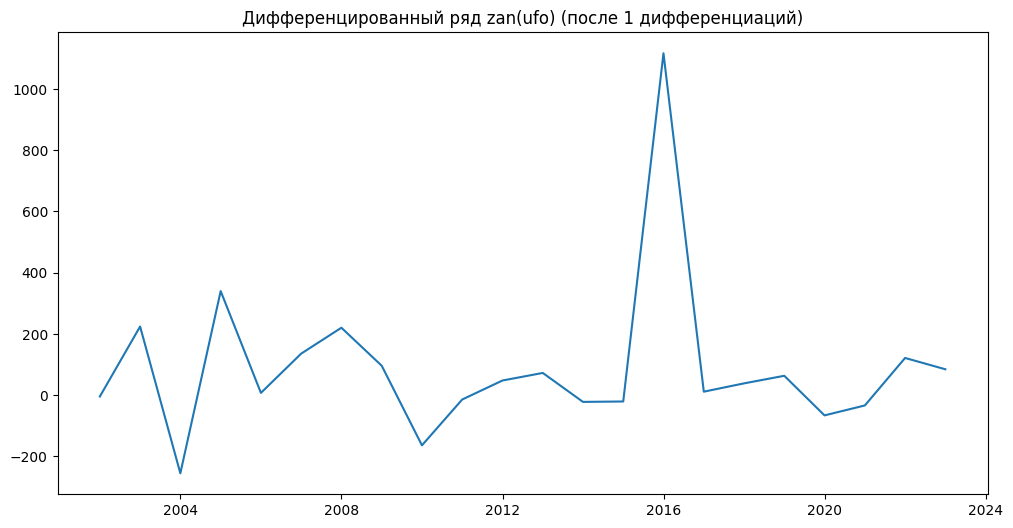

,zan(ufo)_diff_1
year,
2001-12-31,-4.08
2002-12-31,224.39
2003-12-31,-254.88
2004-12-31,340.00
2005-12-31,7.62
2006-12-31,135.76
2007-12-31,220.47
2008-12-31,96.29
2009-12-31,-163.61


In [ ]:
difference_for_stationarity(df, 'zan(ufo)')

In [ ]:
def adf_test(series):
    """
    Проводит тест на единичный корень(ADF-тест) для проверки стационарности
    временного ряда.

    Аргументы:
    series : pandas.Series
      Временной ряд, который нужно протестировать на стационарность.

    Возвращает:
    bool
      True, если временной ряд стационарен(p-value <= 0.05), иначе False.

    Дополнительно:
    Выводит на экран статистику ADF, p-value и критические значения.
    """
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    return result[1] <= 0.05

In [ ]:
adf_test(df['bezr(ufo)'])

ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}


False

In [ ]:
def differentiate_series(data, variable_name, max_diff=5):
    """
    Приводит временной ряд из датафрейма к стационарному виду путём
    дифференциации.

    Аргументы:
    data : pandas.DataFrame
      Датафрейм, содержащий временные ряды.
    variable_name : str
      Название переменной(столбца), который нужно дифференцировать для
      достижения стационрности.
    max_diff : int, optional
      Максимальное количество дифференциаций, которые можно выполнить.
      По умолчанию 5.

    Возвращает:
      -pandas.DataFrame : Датафрейм с дифференцированными временными рядами.

    Дополнительно:
    Если ряд становится стационарным до достижения максимального количества
    дифференциаций, процесс останавливается и возвращается результат на этом
    этапе. Если ряд уже стационарен, выводится соответствующее сообщение.
    """
    series = data[variable_name]
    df_diff = pd.DataFrame()
    num_diff = 0

    if adf_test(series):
      print('Исходный ряд уже стационарен. Дифференциация не требуется.')
      return None

    while num_diff <= max_diff:
      if adf_test(series):
        print(f'Ряд стационарен после {num_diff} дифференциаций.')
        break
      series = series.diff().dropna()
      num_diff += 1
      suffix = f'_diff_{num_diff}'
      df_diff[f'{variable_name}{suffix}'] = series

    if num_diff > max_diff and not adf_test(series):
      print(f'Превышено максимально количество дифференциаций ({max_diff})./nРяд всё ещё не стационарен')

    return df_diff

In [ ]:
differentiate_series(df, 'bezr(ufo)')

ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: 0.8294880679823573
p-value: 0.9920975535603199
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Statistic: 1.576961915657635
p-value: 0.9977867869711872
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Statistic: 1.0763952559368515
p-value: 0.9950100444711059
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Statistic: -2.704969712973984
p-value: 0.073182232742945
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Statistic: -6.467743170174151
p-va

,bezr(ufo)_diff_1,bezr(ufo)_diff_2,bezr(ufo)_diff_3,bezr(ufo)_diff_4,bezr(ufo)_diff_5
year,,,,,
2001-12-31,-108.97,NaN,NaN,NaN,NaN
2002-12-31,-117.17,-8.20,NaN,NaN,NaN
2003-12-31,106.16,223.33,231.53,NaN,NaN
2004-12-31,-98.76,-204.92,-428.25,-659.78,NaN
2005-12-31,-89.55,9.21,214.13,642.38,1302.16
2006-12-31,1.11,90.66,81.45,-132.68,-775.06
2007-12-31,-73.01,-74.12,-164.78,-246.23,-113.55
2008-12-31,-36.08,36.93,111.05,275.83,522.06
2009-12-31,151.16,187.24,150.31,39.26,-236.57


In [ ]:
def plot_stationary_series(series, variable_name, num_diff):
    """
    Визуализирует дифференцированный временной ряд.

    Аргументы:
    series : pandas.Series
      Дифференцированный временной ряд, который нужно визуализировать.
    variable_name : str
      Название переменной(столбца), соответствующего данному временному ряду.
    num_diff : int
      Количество проведённых дифференциаций, после которых получен данный ряд.

    Возвращает:
      None

    Дополнительно:
    Отображает график дифференцированного временного ряда.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(series)
    plt.title(f'Дифференцированный ряд {variable_name} (после {num_diff} дифференциаций)')
    plt.show()

In [ ]:
df_diff = differentiate_series(df, 'bezr(ufo)')

ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: 0.8294880679823573
p-value: 0.9920975535603199
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Statistic: 1.576961915657635
p-value: 0.9977867869711872
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Statistic: 1.0763952559368515
p-value: 0.9950100444711059
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Statistic: -2.704969712973984
p-value: 0.073182232742945
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Statistic: -6.467743170174151
p-va

In [ ]:
df_diff

,bezr(ufo)_diff_1,bezr(ufo)_diff_2,bezr(ufo)_diff_3,bezr(ufo)_diff_4,bezr(ufo)_diff_5
year,,,,,
2001-12-31,-108.97,NaN,NaN,NaN,NaN
2002-12-31,-117.17,-8.20,NaN,NaN,NaN
2003-12-31,106.16,223.33,231.53,NaN,NaN
2004-12-31,-98.76,-204.92,-428.25,-659.78,NaN
2005-12-31,-89.55,9.21,214.13,642.38,1302.16
2006-12-31,1.11,90.66,81.45,-132.68,-775.06
2007-12-31,-73.01,-74.12,-164.78,-246.23,-113.55
2008-12-31,-36.08,36.93,111.05,275.83,522.06
2009-12-31,151.16,187.24,150.31,39.26,-236.57


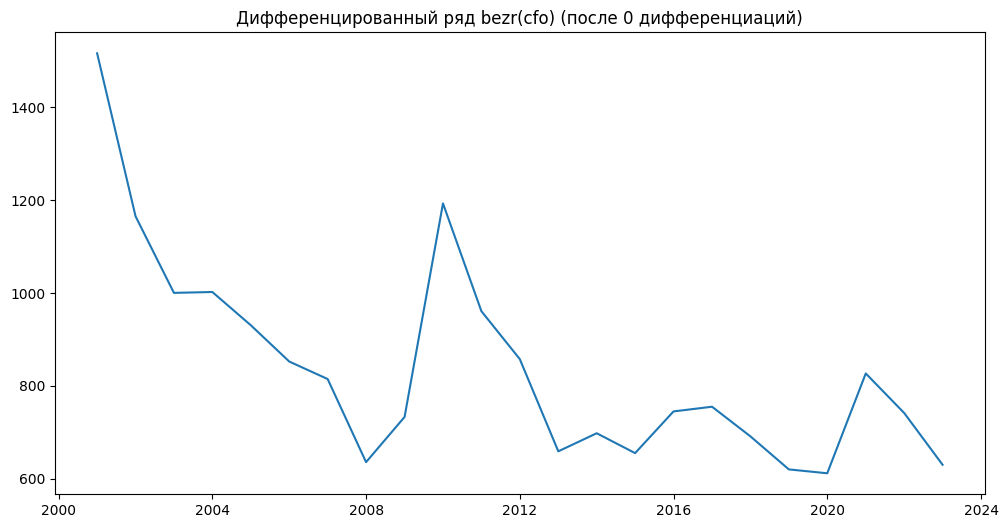

In [ ]:
plot_stationary_series(df['bezr(cfo)'], 'bezr(cfo)', num_diff=0)

In [ ]:
# Функция для построения ACF и PACF
def plot_acf_pacf(series, lags=10):
    """
    Строит графики автокорреляционной функции(ACF) и частичной
    автокорреляционной функции(PACF) для стационарного временного
    ряда.

    Аргументы:
    series : pandas.Series
        Стационарный временной ряд, для которого нужно построить
        графики ACF и PACF.
    lags : int
        Количество лагов для анализа.

    Возвращает:
    None

    Дополнительно:
    Отображает два графика: ACF и PACF.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    #ACF
    plot_acf(series, ax=axes[0])
    axes[0].set_title('ACF')

    #PACF
    plot_pacf(series, ax=axes[1])
    axes[1].set_title('PACF')

    plt.show()

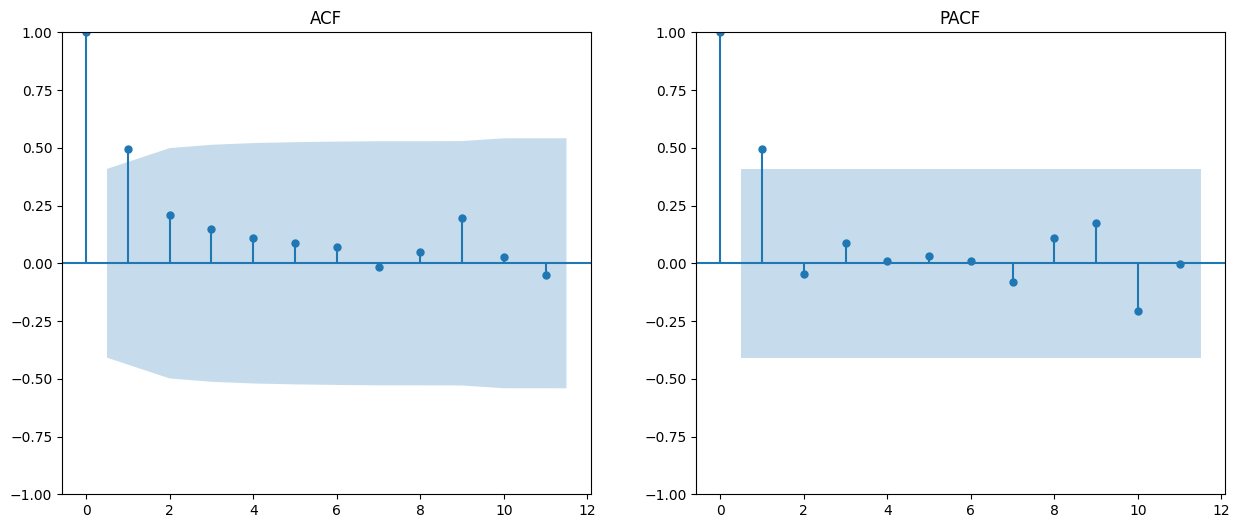

In [ ]:
plot_acf_pacf(df['bezr(cfo)'].dropna(), lags=10)

In [ ]:
def pipeline(data, variable_name, max_diff=5, plot_diff_series=True, plot_acf_pacf_flag=True, lags=10):
    """
    Выполняет конвейерный анализ временного ряда, включая проверку на стационарность,
    дифференциацию, визуализацию ряда и построение ACF/PACF графиков.

    Аргументы:
    data : pandas.DataFrame
        Датафрейм, содержащий временные ряды.
    variable_name : str
        Название переменной (столбца), которую нужно анализировать.
    max_diff : int, optional
        Максимальное количество дифференциаций для достижения стационарности. По умолчанию 5.
    plot_diff_series : bool, optional
        Флаг, определяющий, нужно ли визуализировать дифференцированный ряд. По умолчанию True.
    plot_acf_pacf_flag : bool, optional
        Флаг, определяющий, нужно ли строить графики ACF и PACF. По умолчанию True.
    lags : int, optional
        Количество лагов для графиков ACF и PACF. По умолчанию 10.

    Возвращает:
    None

    Дополнительно:
    В зависимости от переданных параметров, функция выполняет соответствующие шаги анализа.
    """
    # Шаг 1: Дифференциация временного ряда для достижения стационарности
    df_diff = differentiate_series(data, variable_name, max_diff=max_diff)

    if df_diff is not None:
        # Если ряд был дифференцирован, извлекаем последний стационарный ряд
        last_stationary_series = df_diff.iloc[:, -1]
        num_diff = len(df_diff.columns)

        # Шаг 2: Визуализация дифференцированного ряда
        if plot_diff_series:
            plot_stationary_series(last_stationary_series, variable_name, num_diff)

        # Шаг 3: Построение графиков ACF и PACF для стационарного ряда
        if plot_acf_pacf_flag:
            plot_acf_pacf(last_stationary_series.dropna(), lags=lags)
    else:
        # Если дифференциация не потребовалась и ряд изначально стационарен
        print('Исходный ряд уже стационарен. Дифференциация не требуется.')

        # Визуализация исходного стационарного ряда
        if plot_diff_series:
            plt.figure(figsize=(12, 6))
            plt.plot(data[variable_name])
            plt.title(f'Исходный стационарный ряд {variable_name}')
            plt.show()

        # Построение графиков ACF и PACF для исходного ряда
        if plot_acf_pacf_flag:
            plot_acf_pacf(data[variable_name], lags=lags)

    print("Анализ завершен.")

ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: 0.8294880679823573
p-value: 0.9920975535603199
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Statistic: 1.576961915657635
p-value: 0.9977867869711872
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Statistic: 1.0763952559368515
p-value: 0.9950100444711059
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Statistic: -2.704969712973984
p-value: 0.073182232742945
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Statistic: -6.467743170174151
p-va

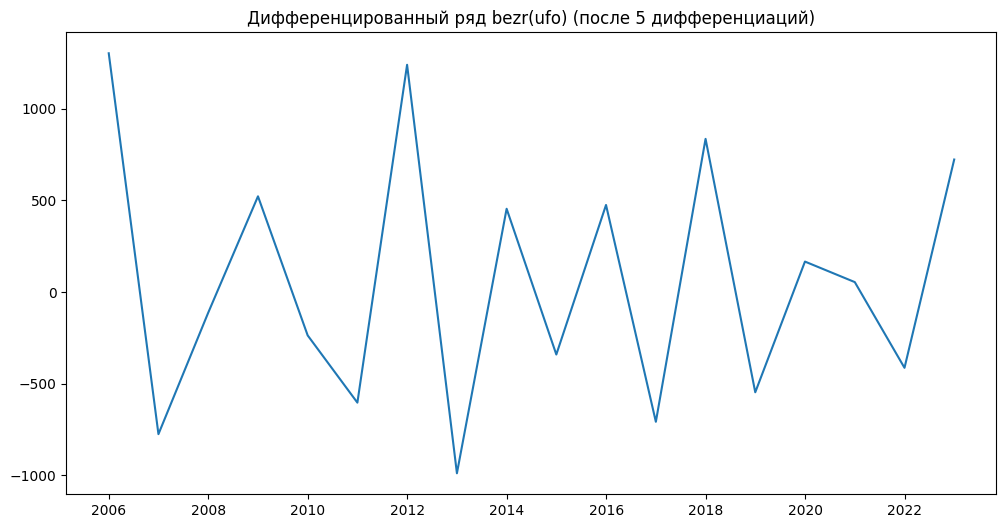

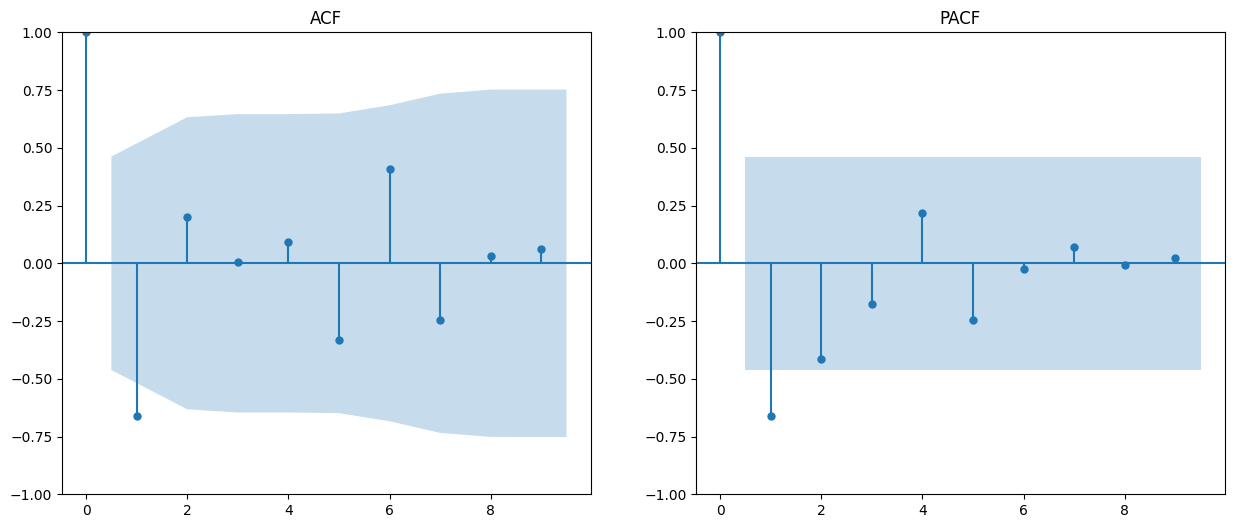

Анализ завершен.


In [ ]:
pipeline(df, 'bezr(ufo)', plot_diff_series=True, plot_acf_pacf_flag=True)

ADF Statistic: -3.811750648580236
p-value: 0.0027893528260389696
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
Исходный ряд уже стационарен. Дифференциация не требуется.
Исходный ряд уже стационарен. Дифференциация не требуется.


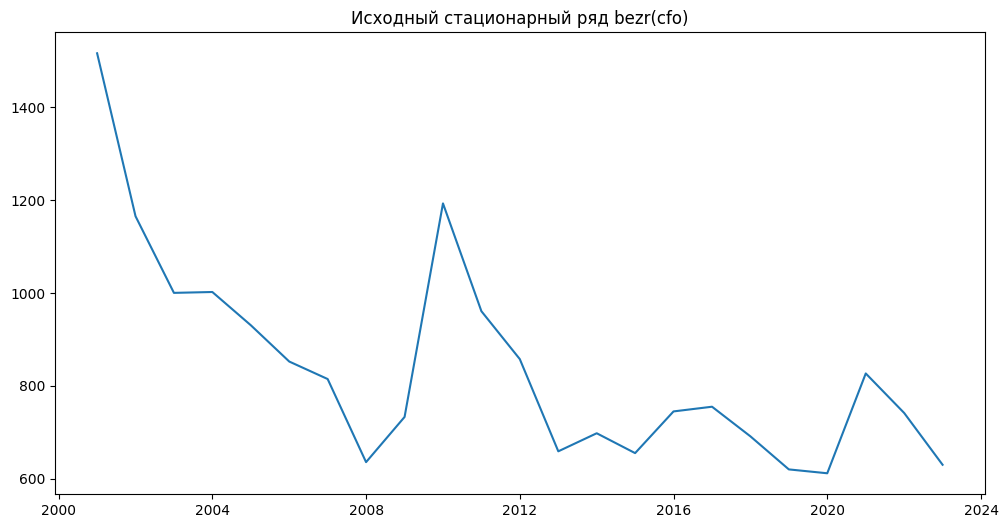

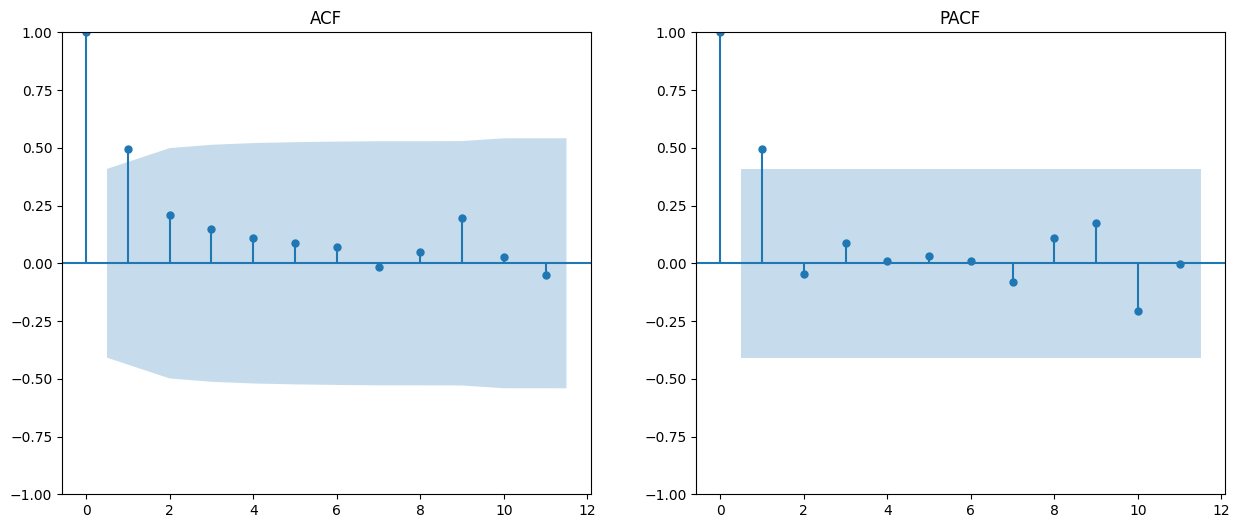

Анализ завершен.


In [ ]:
pipeline(df, 'bezr(cfo)', plot_diff_series=True, plot_acf_pacf_flag=True)

In [ ]:
pipeline(df, 'bezr(ufo)', plot_diff_series=False, plot_acf_pacf_flag=False)

ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: -2.5448248980818597
p-value: 0.10494527019480482
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
ADF Statistic: 0.8294880679823573
p-value: 0.9920975535603199
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Statistic: 1.576961915657635
p-value: 0.9977867869711872
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
ADF Statistic: 1.0763952559368515
p-value: 0.9950100444711059
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Statistic: -2.704969712973984
p-value: 0.073182232742945
Critical Values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
ADF Statistic: -6.467743170174151
p-va

In [ ]:
pipeline(df, 'bezr(cfo)', plot_diff_series=False, plot_acf_pacf_flag=False)

ADF Statistic: -3.811750648580236
p-value: 0.0027893528260389696
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
Исходный ряд уже стационарен. Дифференциация не требуется.
Исходный ряд уже стационарен. Дифференциация не требуется.
Анализ завершен.


ADF Statistic: 3.127960427040384
p-value: 1.0
Critical Values: {'1%': -3.889265672705068, '5%': -3.0543579727254224, '10%': -2.66698384083045}
ADF Statistic: 3.127960427040384
p-value: 1.0
Critical Values: {'1%': -3.889265672705068, '5%': -3.0543579727254224, '10%': -2.66698384083045}
ADF Statistic: -3.2021400793653907
p-value: 0.01986113673562961
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
Ряд стационарен после 1 дифференциаций.


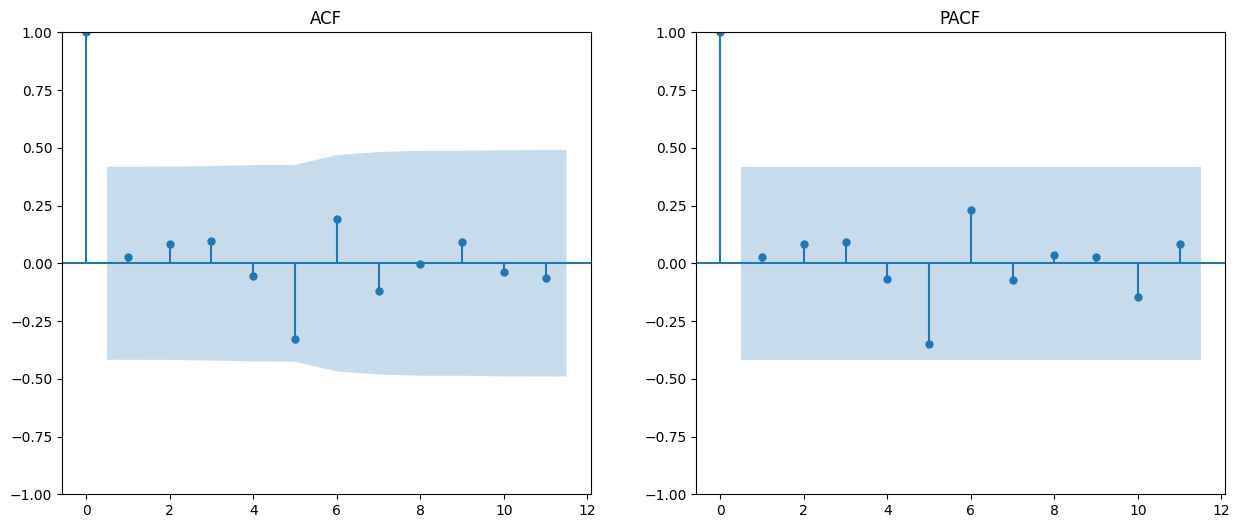

Анализ завершен.


In [ ]:
pipeline(df, 'srd(cfo)', plot_diff_series=False, plot_acf_pacf_flag=True)

ADF Statistic: -3.811750648580236
p-value: 0.0027893528260389696
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}
Исходный ряд уже стационарен. Дифференциация не требуется.
Исходный ряд уже стационарен. Дифференциация не требуется.


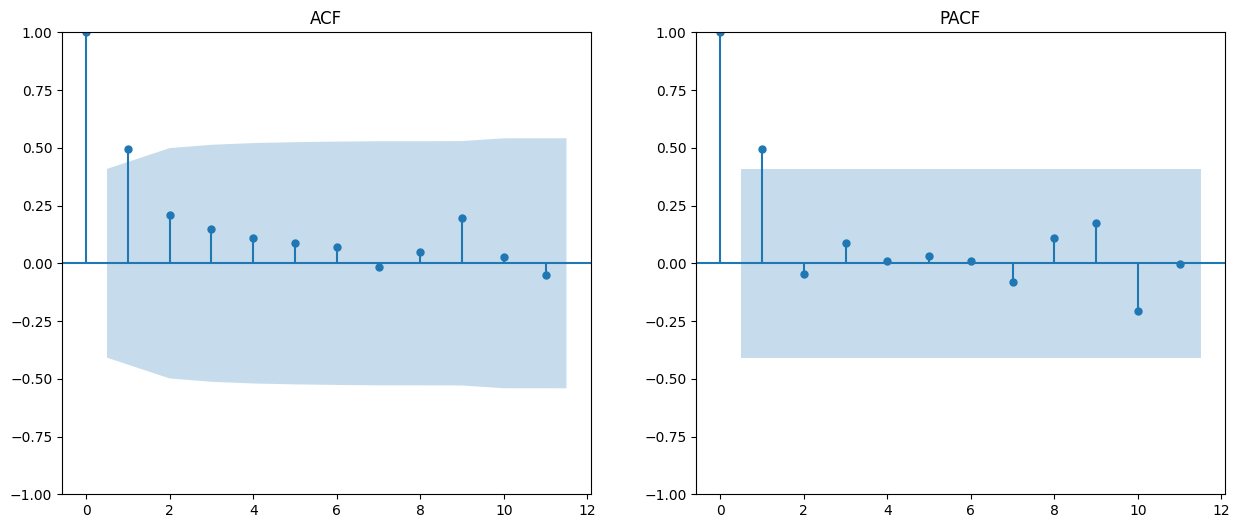

Анализ завершен.


In [ ]:
pipeline(df, 'bezr(cfo)', plot_diff_series=False, plot_acf_pacf_flag=True)

In [ ]:
# Функция проверки сезонности
def check_seasonality(series, seasonal_period=12):
    """
    Проверяет наличие сезонности во временном ряде с использованием ACF.

    Аргументы:
    series : pandas.Series
        Временной ряд для анализа.
    seasonal_period : int
        Период сезонности.

    Возвращает:
    bool
        True, если сезонность обнаружена, иначе False.
    """
    acf_values_seasonal = acf(series, nlags=seasonal_period)
    critical_value = 1.96 / np.sqrt(len(series))

    plt.figure(figsize=(10, 6))
    plt.stem(range(1, seasonal_period + 1), acf_values_seasonal[1:])
    plt.xlabel('Лаг')
    plt.ylabel('Значение ACF')
    plt.title('Сезонный ACF для дифференцированного ряда')
    plt.show()

    has_seasonality = any(np.abs(acf_values_seasonal[1:]) > critical_value)
    if has_seasonality:
        print("Обнаружена сезонность в дифференцированном ряду.")
    else:
        print("Сезонность в дифференцированном ряду не обнаружена.")

    return has_seasonality

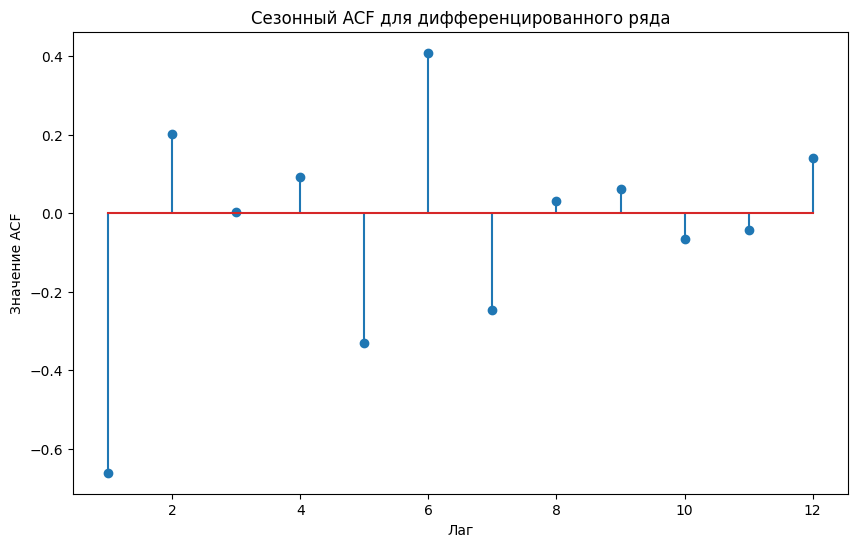

Обнаружена сезонность в дифференцированном ряду.


True

In [ ]:
check_seasonality(df_diff['bezr(ufo)_diff_5'].dropna())

In [ ]:
def split_train_test_by_ratio(series, train_size=0.7):
    """
    Делит временной ряд на обучающую и тестовую выборки по соотношению.

    Аргументы:
    series : pandas.Series
        Временной ряд, который нужно разделить.
    train_size : float, optional
        Доля обучающей выборки (по умолчанию 0.8).

    Возвращает:
    train : pandas.Series
        Обучающая выборка.
    test : pandas.Series
        Тестовая выборка.
    """
    split_index = int(len(series) * train_size)
    train = series[:split_index]
    test = series[split_index:]
    return train, test

In [ ]:
def train_arima_model(train, p, d, q):
    """
    Обучает модель ARIMA с заданными параметрами p, d, q.

    Аргументы:
    train : pandas.Series
        Обучающая выборка временного ряда.
    p : int
        Параметр p модели ARIMA.
    d : int
        Параметр d модели ARIMA.
    q : int
        Параметр q модели ARIMA.

    Возвращает:
    model : ARIMA
        Обученная модель ARIMA.
    """
    model = ARIMA(train, order=(p, d, q))
    fitted_model = model.fit()
    return fitted_model

In [ ]:
#Рабочий вариант
def forecast_arima(series, p, d, q, future_periods=3):
    """
    Предсказывает значения временного ряда с помощью модели ARIMA.

    Аргументы:
    series: pandas.Series
        Временной ряд.
    p, d, q: int
        Параметры модели ARIMA.
    future_periods: int, optional
        Количество периодов для прогнозирования после тестового периода.

    Возвращает:
    forecast: pandas.Series
        Прогноз на тестовый период.
    future_forecast: pandas.Series
        Прогноз на будущие периоды.
    conf_int: pandas.DataFrame
        Доверительные интервалы для прогнозируемых значений.
    """

    # Разделение данных
    train, test = split_train_test_by_ratio(series)

    # Установка частоты индекса
    if test.index.freq is None:
        test = test.asfreq('Y')  # Установка годовой частоты с концом года в декабре

    # Обучение модели
    model = train_arima_model(train, p, d, q)

    # Прогноз на тестовый период
    forecast = model.forecast(steps=len(test))
    conf_int = model.get_forecast(steps=len(test)).conf_int()

    # Обновляем модель на основе всего ряда, включая тестовый период
    full_model = train_arima_model(series, p, d, q)

    # Прогноз на будущие периоды
    future_forecast = full_model.forecast(steps=future_periods)
    future_conf_int = full_model.get_forecast(steps=future_periods).conf_int(alpha=0.05)

    # Создание индекса для будущего прогноза
    future_dates = pd.date_range(start=test.index[-1], periods=future_periods + 1, freq='Y')[1:]
    future_forecast = pd.Series(future_forecast, index=future_dates)

    return forecast, future_forecast, conf_int, future_conf_int

In [ ]:
def evaluate_forecast(test, forecast):
    """
    Оценивает прогноз с использованием метрик RMSE, MAE, MAPE.

    Аргументы:
    test : pandas.Series
        Реальные значения из тестовой выборки.
    forecast : pandas.Series
        Прогнозируемые значения.

    Возвращает:
    rmse : float
        Корень из средней квадратичной ошибки.
    mae : float
        Средняя абсолютная ошибка.
    mape : float
        Средняя абсолютная процентная ошибка.
    """
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast) * 100
    return rmse, mae, mape

In [ ]:
def plot_forecast(series, train, test, forecast, conf_int, future_forecast, future_conf_int):
    """
    Визуализирует исходный ряд, обучающую выборку, прогноз на тестовом периоде и прогноз на будущие периоды.

    Аргументы:
    series : pandas.Series
        Исходный временной ряд.
    train : pandas.Series
        Обучающая выборка.
    test : pandas.Series
        Тестовая выборка.
    forecast : pandas.Series
        Прогноз на тестовом периоде.
    conf_int : pandas.DataFrame
        Доверительные интервалы для прогнозируемых значений.
    future_forecast : pandas.Series
        Прогноз на будущие периоды.
    future_conf_int : pandas.DataFrame
        Доверительные интервалы для будущих прогнозов.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original Series')
    plt.plot(test.index, test, label='Test')
    plt.plot(forecast.index, forecast, label='Forecast')

    # Доверительные интервалы для тестового периода
    plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    # Прогноз на будущее
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast', linestyle='--')

    # Доверительные интервалы для будущих периодов
    plt.fill_between(future_forecast.index, future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='lightblue', alpha=0.3)

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('ARIMA Model Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#Рабочий вариант
def arima_pipeline(series, p, d, q, train_size=0.8, future_periods=3):
    """
    Пайплайн для выполнения всех шагов ARIMA анализа, включая разделение данных, обучение модели,
    прогнозирование, оценку прогноза и визуализацию результатов.

    Аргументы:
    series : pandas.Series
        Временной ряд.
    p, d, q : int
        Параметры модели ARIMA.
    train_size : float, optional
        Доля обучающей выборки (по умолчанию 0.8).
    future_periods : int, optional
        Количество периодов для прогнозирования после тестового периода.

    Возвращает:
    metrics : dict

        Метрики оценки модели (RMSE, MAE, MAPE).
    future_forecast : pandas.Series
        Прогнозы на будущие периоды.
    """
    # 1. Разделение данных
    train, test = split_train_test_by_ratio(series, train_size)

    # 2. Обучение модели ARIMA
    model = train_arima_model(train, p, d, q)

    # 3. Прогнозирование на тестовом периоде и на будущее
    forecast, future_forecast, conf_int, future_conf_int = forecast_arima(series, p, d, q, future_periods)

    # 4. Оценка прогноза
    rmse, mae, mape = evaluate_forecast(test, forecast)
    metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    # 5. Визуализация результатов
    plot_forecast(series, train, test, forecast, conf_int, future_forecast, future_conf_int)

    return metrics, future_forecast

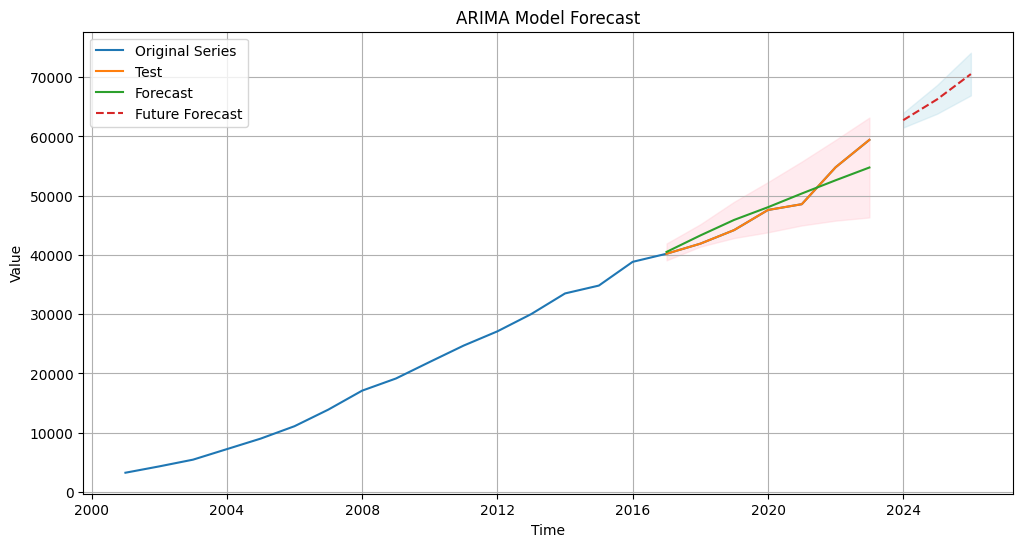

({'RMSE': 2237.339402996339,
  'MAE': 1791.9393723105645,
  'MAPE': 3.501993223999268},
 2023-12-31    62744.201253
 2024-12-31    66261.413341
 2025-12-31    70534.061161
 Freq: A-DEC, Name: predicted_mean, dtype: float64)

In [ ]:
arima_pipeline(df['srd(cfo)'], p=1, d=1, q=5, train_size=0.7, future_periods=3)

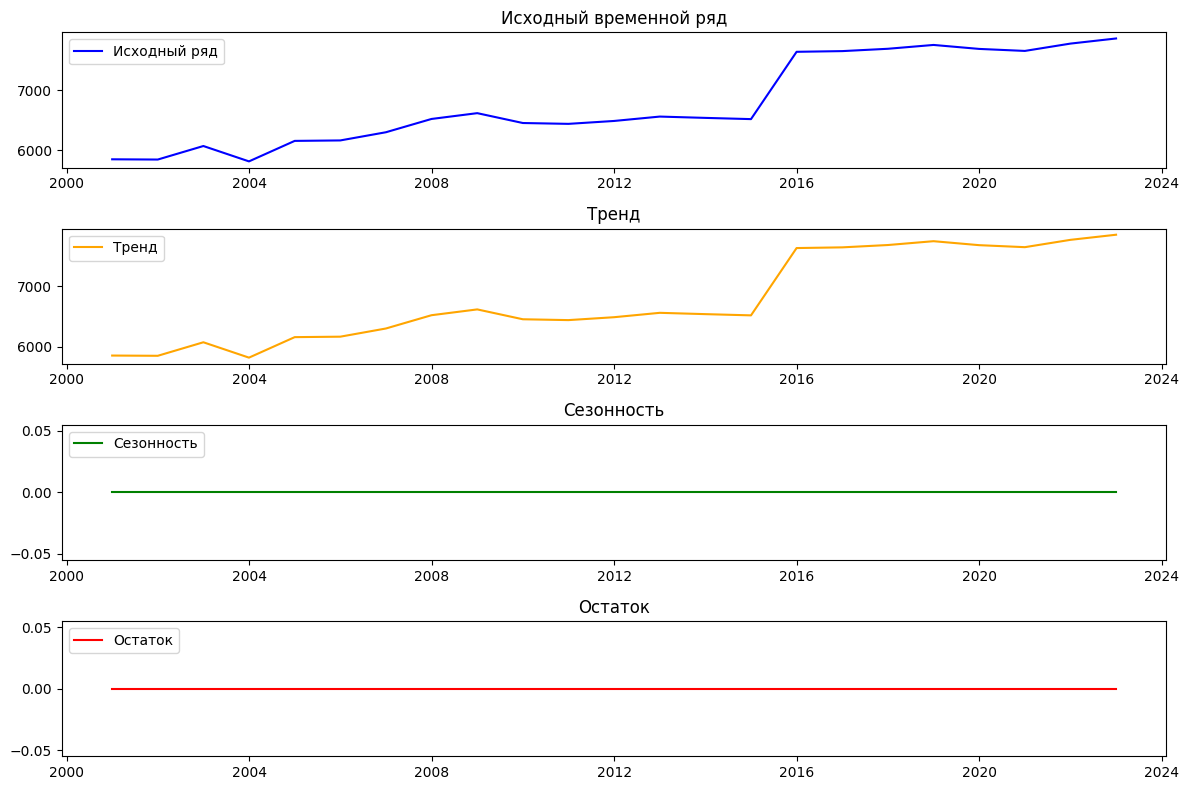

In [ ]:
# Декомпозиция временного ряда на тренд, сезонность и остаток
result = seasonal_decompose(df['zan(ufo)'], model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Визуализация результатов
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['zan(ufo)'], label='Исходный ряд', color='blue')
plt.legend(loc='upper left')
plt.title('Исходный временной ряд')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Тренд', color='orange')
plt.legend(loc='upper left')
plt.title('Тренд')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Сезонность', color='green')
plt.legend(loc='upper left')
plt.title('Сезонность')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Остаток', color='red')
plt.legend(loc='upper left')
plt.title('Остаток')

plt.tight_layout()
plt.show()

In [ ]:
'''def double_exponential_smoothing(df, variable_name, smoothing_level=0.7, smoothing_slope=0.9, future_periods=3):
    """
    Применяет двойное экспоненциальное сглаживание и прогнозирует будущее.

    Аргументы:
        df : pandas.DataFrame
            Датафрейм с временным рядом.
        variable_name : str
            Название временного ряда.
        smoothing_level : float, optional
            Уровень сглаживания. По умолчанию 0.7.
        smoothing_slope : float, optional
            Сглаживание тренда. По умолчанию 0.9.
        future_periods : int, optional
            Число будущих периодов для прогноза. По умолчанию 3.

    Возвращает:
        forecast_future : pandas.Series
            Прогноз на будущие периоды.
    """
    model = Holt(df[variable_name], exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
    forecast_double_exp_smoothing = model.fittedvalues

    aic, bic = model.aic, model.bic
    rmse = np.sqrt(mean_squared_error(df[variable_name], forecast_double_exp_smoothing))
    mae = mean_absolute_error(df[variable_name], forecast_double_exp_smoothing)
    mape = 100 * np.mean(np.abs((df[variable_name] - forecast_double_exp_smoothing) / df[variable_name]))

    forecast_future = model.forecast(steps=future_periods)
    forecast_future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(years=1), periods=future_periods, freq='Y')
    forecast_future.index = forecast_future_index

    print(f'AIC: {aic}, BIC: {bic}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%')

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[variable_name], label='Исходный ряд', color='blue')
    plt.plot(df.index, forecast_double_exp_smoothing, label='Прогноз сглаживания', color='green')
    plt.plot(forecast_future_index, forecast_future, label='Прогноз на будущее', color='orange', linestyle='--', marker='o')
    plt.title('Двойное экспоненциальное сглаживание')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('\nПрогноз на будущее:')
    for date, value in forecast_future.items():
        print(f'{date.strftime("%Y-%m-%d")}: {value}')

    return forecast_future'''

In [ ]:
def find_optimal_parameters(df, variable_name):
    """
    Находит оптимальные параметры для модели экспоненциального сглаживания с использованием метода наименьших квадратов (MSE).

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временные ряды.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.

    Возвращает:
        tuple
            Кортеж, содержащий оптимальные параметры smoothing_level и smoothing_slope.
    """
    # Задаем диапазон значений для параметров
    smoothing_level_range = np.arange(0.1, 0.91, 0.1)
    smoothing_slope_range = np.arange(0.1, 0.91, 0.1)

    # Инициализация минимальной ошибки
    min_rmse = np.inf

    for smoothing_level in smoothing_level_range:
        for smoothing_slope in smoothing_slope_range:
            # Подгонка модели с текущими параметрами
            model_double_exp_smoothing = Holt(df[variable_name], exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
            forecast_double_exp_smoothing = model_double_exp_smoothing.fittedvalues
            rmse = np.sqrt(mean_squared_error(df[variable_name], forecast_double_exp_smoothing))

            # Обновление минимальной ошибки и оптимальных параметров
            if rmse < min_rmse:
                min_rmse = rmse
                optimal_smoothing_level = smoothing_level
                optimal_smoothing_slope = smoothing_slope

    # Вывод оптимальных параметров и RMSE
    print('Оптимальные параметры smoothing_level:', optimal_smoothing_level)
    print('Оптимальные параметры smoothing_slope:', optimal_smoothing_slope)
    print('Минимальная RMSE:', min_rmse)

    return optimal_smoothing_level, optimal_smoothing_slope

In [ ]:
find_optimal_parameters(df, 'srd(cfo)')

Оптимальные параметры smoothing_level: 0.7000000000000001
Оптимальные параметры smoothing_slope: 0.9
Минимальная RMSE: 1255.78136607734


(0.7000000000000001, 0.9)

In [ ]:
def split_train_test_by_ratio(df, variable_name, train_size=0.7):
    """
    Делит временной ряд на обучающую и тестовую выборки по указанному соотношению.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.
        train_size : float, optional
            Доля данных для обучения (по умолчанию 0.7).

    Возвращает:
        tuple
            Кортеж, содержащий обучающую (train) и тестовую (test) выборки в виде pandas.Series.
    """
    split_index = int(len(df) * train_size)
    train = df.iloc[:split_index][variable_name]
    test = df.iloc[split_index:][variable_name]
    return train, test

In [ ]:
def train_double_exponential_smoothing(train, smoothing_level=0.7, smoothing_slope=0.9):
    """
    Обучает модель двойного экспоненциального сглаживания на обучающей выборке.

    Аргументы:
        train : pandas.Series
            Обучающая выборка временного ряда.
        smoothing_level : float, optional
            Уровень сглаживания. По умолчанию 0.7.
        smoothing_slope : float, optional
            Сглаживание тренда. По умолчанию 0.9.

    Возвращает:
        HoltWintersResults
            Обученная модель двойного экспоненциального сглаживания.
    """
    model = Holt(train, exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
    return model

In [ ]:
def forecast_double_exponential_smoothing(train, test, smoothing_level=0.7, smoothing_slope=0.9, future_periods=3):
    """
    Прогнозирует значения временного ряда с использованием модели двойного экспоненциального сглаживания.

    Аргументы:
        train : pandas.Series
            Обучающая выборка временного ряда.
        test : pandas.Series
            Тестовая выборка временного ряда.
        smoothing_level : float, optional
            Уровень сглаживания. По умолчанию 0.7.
        smoothing_slope : float, optional
            Сглаживание тренда. По умолчанию 0.9.
        future_periods : int, optional
            Количество периодов для прогнозирования после тестового периода. По умолчанию 3.

    Возвращает:
        tuple
            Кортеж, содержащий прогноз на тестовом периоде (forecast) и прогноз на будущие периоды (future_forecast).
    """
    # Прогноз на тестовый период
    model = Holt(train, exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
    forecast = model.forecast(steps=len(test))

    # Создание модели на основе данных train + test
    combined_series = pd.concat([train, test])
    full_model = Holt(combined_series, exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    # Прогноз на будущие периоды начиная с конца тестового периода
    future_forecast = full_model.forecast(steps=future_periods)

    return forecast, future_forecast

In [ ]:
def evaluate_forecast(test, forecast):
    """
    Оценивает точность прогноза с использованием метрик RMSE, MAE, MAPE.

    Аргументы:
        test : pandas.Series
            Реальные значения из тестовой выборки.
        forecast : pandas.Series
            Прогнозируемые значения.

    Возвращает:
        tuple
            Кортеж, содержащий RMSE, MAE и MAPE (соответственно).
    """
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast) * 100
    return rmse, mae, mape

In [ ]:
def plot_double_exponential_smoothing(df, train, test, forecast, future_forecast, variable_name):
    """
    Визуализирует временной ряд, обучающую выборку, прогноз на тестовом периоде и прогноз на будущие периоды.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        train : pandas.Series
            Обучающая выборка.
        test : pandas.Series
            Тестовая выборка.
        forecast : pandas.Series
            Прогноз на тестовом периоде.
        future_forecast : pandas.Series
            Прогноз на будущие периоды.
        variable_name : str
            Название временного ряда.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[variable_name], label='Исходный ряд', color='blue')
    plt.plot(train.index, train, label='Обучающая выборка', color='green')
    plt.plot(test.index, forecast, label='Прогноз на тестовом периоде', color='orange')

    future_forecast_index = pd.date_range(start=test.index[-1] + pd.DateOffset(years=1), periods=len(future_forecast), freq='Y')
    plt.plot(future_forecast_index, future_forecast, label='Прогноз на будущее', linestyle='--', marker='o', color='red')

    plt.title('Двойное экспоненциальное сглаживание')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def double_exponential_smoothing_pipeline(df, variable_name, smoothing_level=0.7, smoothing_slope=0.9, train_size=0.7, future_periods=3):
    """
    Пайплайн для выполнения анализа с использованием двойного экспоненциального сглаживания, включая разделение данных, обучение модели, прогнозирование, оценку прогноза и визуализацию результатов.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.
        smoothing_level : float, optional
            Уровень сглаживания. По умолчанию 0.7.
        smoothing_slope : float, optional
            Сглаживание тренда. По умолчанию 0.9.
        train_size : float, optional
            Доля обучающей выборки (по умолчанию 0.7).
        future_periods : int, optional
            Количество периодов для прогнозирования после тестового периода (по умолчанию 3).

    Возвращает:
        tuple
            Кортеж, содержащий метрики оценки модели (RMSE, MAE, MAPE) и прогноз на будущие периоды.
    """
    # 1. Разделение данных
    train, test = split_train_test_by_ratio(df, variable_name, train_size)

    # 2. Прогнозирование
    forecast, future_forecast = forecast_double_exponential_smoothing(train, test, smoothing_level, smoothing_slope, future_periods)

    # 3. Оценка прогноза
    rmse, mae, mape = evaluate_forecast(test, forecast)
    metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    # 4. Визуализация
    plot_double_exponential_smoothing(df, train, test, forecast, future_forecast, variable_name)

    return metrics, future_forecast

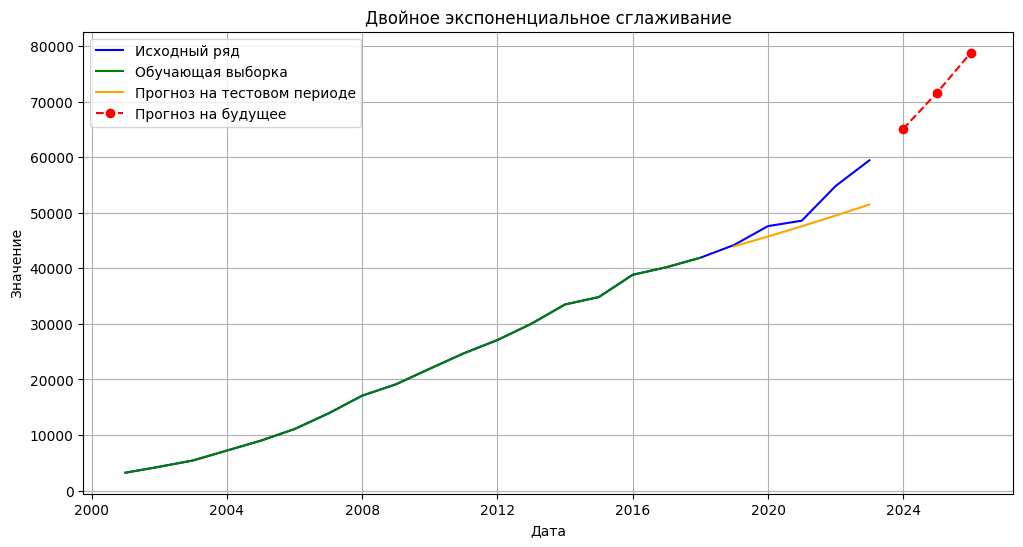

({'RMSE': 4386.443220733806,
  'MAE': 3280.284429229265,
  'MAPE': 5.9321861127423565},
 2023-12-31    65085.364953
 2024-12-31    71604.127943
 2025-12-31    78775.791487
 Freq: A-DEC, dtype: float64)

In [ ]:
double_exponential_smoothing_pipeline(df, 'srd(cfo)', smoothing_level=0.7, smoothing_slope=0.9, train_size=0.8, future_periods=3)

In [ ]:
def prepare_data_prophet(df, variable_name):
    '''
    Подготовка данных для модели Prophet, включая преобразование формата данных.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.

    Возвращает:
        df_prophet : pandas.DataFrame
            Датафрейм, подготовленный для использования в модели Prophet, с
            переименованными столюцами.
    '''
    df_prophet = df.reset_index().rename(columns={'year': 'ds', variable_name: 'y'})
    return df_prophet

In [ ]:
def train_prophet_model(df_prophet):
    '''
    Обучение модели Prophet на подготовленных данных.

    Аргументы:
        df_prophet : pandas.DataFrame
            Датафрейм с временным рядом, подготовленный для модели Prophet.

    Возвращает:
        model : Prophet
            Обученная модель Prophet.
    '''
    model = Prophet()
    model.fit(df_prophet)
    return model

In [ ]:
def forecast_and_plot_prophet(model, periods=3):
    '''
    Построение прогноза с использованием модели Prophet и визуализация рузультатов.

    Аргументы:
        model : Prophet
            Обученная модель Prophet.
        periods : int, optional
            Количество периодов для прогнозирования(по умолчанию 3).

    Возвращает:
        forecast : pandas.DataFrame
            Датафрейм с прогнозируемыми значениями и доверительными интервалами.
    '''
    future = model.make_future_dataframe(periods=periods, freq='Y')
    forecast = model.predict(future)
    fig = model.plot(forecast)
    return forecast

In [ ]:
def evaluate_forecast_prophet(model):
    '''
    Оценка качетва прогноза модели Prophet с использованием кросс-валидации.

    Аргументы:
        model : Prophet
            Обученная модель Prophet.

    Возвращает:
        df_p : pandas.DataFrame
            Датафрейм с метриками оценки качества прогноза.
    '''
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='1095 days')
    df_p = performance_metrics(df_cv)
    return df_p

In [ ]:
def prophet_forecast(df, variable_name):
    '''
    Пайплайн для выполнения всех шагов анализа с использованием модели Prophet,
    включая подоготовку данных, обучение, прогнозирование и оценку.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.

    Возвращает:
        forecast : pandas.DataFrame
            Датафрейм с прогнозируемыми значениями.
        df_p : pandas.DataFrame
            Датафрейм с метриками оценки качества прогноза.
    '''
    df_prophet = prepare_data_prophet(df, variable_name)

    # Проверка содержимого df_prophet
    print(df_prophet.head())  # Добавлено для отладки

    model = train_prophet_model(df_prophet)
    forecast = forecast_and_plot_prophet(model)
    df_p = evaluate_forecast_prophet(model)

    # Вывод числовых значений прогнозов
    print('\nЧисловые значения прогнозов:')
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3))

    # Печать результатов оценки качества прогноза
    print('\nОценка качества прогноза')
    print(df_p.head())

          ds  zan(cfo)  zan(szfo)  zan(ufo)  zan(skfo)  zan(pfo)  zan(uralfo)  \
0 2000-12-31  18014.45    6684.28   5850.76    2603.97  14242.84      5720.02   
1 2001-12-31  18209.86    6788.93   5846.68    2653.35  14225.29      5642.28   
2 2002-12-31  18596.99    6911.31   6071.07    2762.83  14457.40      5733.71   
3 2003-12-31  18609.92    6873.34   5816.19    2765.72  14280.29      5974.66   
4 2004-12-31  18912.54    6970.38   6156.19    2769.92  14378.12      5938.58   

   zan(sfo)  zan(dfo)  bezr(cfo)  ...  bezr(sfo)  bezr(dfo)       y  \
0   7933.75   4020.35    1516.38  ...    1124.00     628.32  3231.0   
1   7817.38   3939.14    1165.34  ...     929.68     521.56  4300.0   
2   8054.44   4071.13    1000.25  ...     868.63     435.51  5436.0   
3   7972.59   4046.69    1002.11  ...     972.79     455.21  7211.0   
4   8179.20   4013.68     930.45  ...     853.29     442.81  8992.0   

   srd(szfo)  srd(ufo)  srd(skfo)  srd(pfo)  srd(uralfo)  srd(sfo)  srd(dfo)  
0     2

  0%|          | 0/35 [00:00<?, ?it/s]


Числовые значения прогнозов:
           ds          yhat    yhat_lower    yhat_upper
23 2023-12-31  59234.766200  57990.916353  60618.400462
24 2024-12-31  61699.620147  60514.296741  62996.208118
25 2025-12-31  64782.097748  63429.900675  66211.810535

Оценка качества прогноза
   horizon           mse         rmse          mae      mape     mdape  \
0 143 days  2.925411e+06  1710.383307  1539.907542  0.101283  0.078742   
1 148 days  3.003897e+06  1733.175512  1588.004547  0.096457  0.076265   
2 153 days  2.396096e+06  1547.932663  1428.073061  0.069592  0.066198   
3 158 days  2.451655e+06  1565.776043  1470.402927  0.067816  0.066198   
4 164 days  2.246452e+06  1498.816912  1397.727234  0.057637  0.044577   

      smape  coverage  
0  0.110254       0.0  
1  0.105147       0.0  
2  0.072929       0.0  
3  0.071096       0.0  
4  0.060010       0.0  


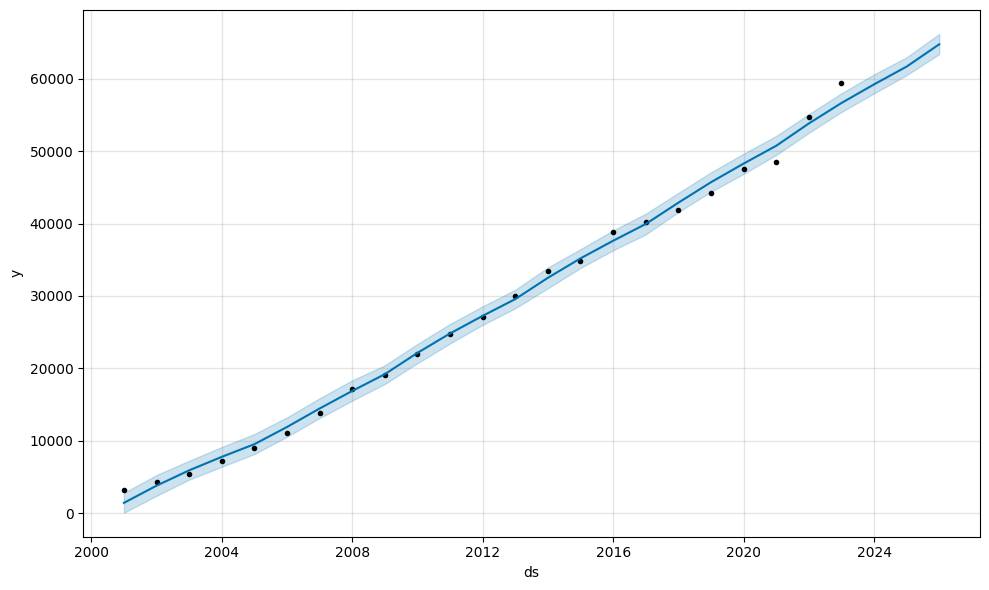

In [ ]:
prophet_forecast(df, 'srd(cfo)')

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  '''
  Создает оконный датасет для обучения модели временного ряда.

  Аргументы:
      series : numpy.ndarray
          Временной ряд в виде массива NumPy.
      window_size : int
          Размер окна для создания последовательных образцов.
      batch_size : int
          Размер пакета для обучения модели.
      shuffle_buffer : int
          Размер буфера для перемешивания данных.

  Возвращает:
      tf.data.Dataset
          Оконный датасет, подготовленный для обучения модели.
  '''
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return(dataset)

In [ ]:
def prepare_data(df, series_name, split_time, window_size, batch_size,
                 shuffle_buffer):
  '''
  Подготавливает данные временного ряда для обучения модели.

  Аргументы:
      df : pandas.DataFrame
          Исходный датафрейм, содержащий временной ряд.
      series_name : str
          Название переменной(столбца) в датафрейме df для анализа.
      split_time : int
          Количество временных отсчётов, используемых для валидации.
      window_size : int
          Размер окна для создания последовательных образцов.
      batch_size : int
          Размер пакета для обучения модели.
      shuffle_buffer : int
          Размер буфера для перемешивания данных.

  Возвращает:
      time_valid : pandas.Index
          Индекс времени для валидационных данных.
      x_valid : numpy.ndarray
          Валидационный данные временного ряда.
      x_valid_prescale : numpy.ndarray
          Валидационные данные временного ряда(перед масштабированием).
      scaler : sklearn.preprocessing.MinMaxScaler
          Объект масштабирования данных.
      dataset : tf.data.Dataset
          Оконный датасет, подготовленный для обучения модели.
  '''
  series = df[series_name]
  time_train = series.index[:split_time]
  x_train = series.values[:split_time]
  time_valid = series.index[split_time:]
  x_valid = series.values[split_time:]

  x_train = x_train.reshape(-1, 1)
  x_valid = x_valid.reshape(-1, 1)
  x_valid_prescale = x_valid

  scaler = MinMaxScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  x_valid = scaler.transform(x_valid)

  dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

  return time_valid, x_valid, x_valid_prescale, scaler, dataset

In [ ]:
def build_model():
  '''
  Строит и компилирует модель для прогнозирования временных рядов.

  Возвращает:
      tf.keras.models.Sequential
          Построенная модель для прогнозирования временных рядов.
  '''
  model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                             input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(260,
                                                         return_sequences=True)),
      tf.keras.layers.Dropout(0.15),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(248)),
      tf.keras.layers.Dropout(0.05),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x*100.0)
  ])

  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss = "mse", optimizer=optimizer, metrics=["mae"])

  return model

In [ ]:
def train_model(model, dataset, epochs):
  '''
  Обучает модель на заданном датасете.

  Аргументы:
      model : tf.keras.models.Model
          Модель для обучения.
      dataset : tf.data.Dataset
          Датасет для обучения модели.
      epochs : int
          Количество эпох обучения.


  Возвращает:
      tf.keras.callbacks.History
          История обучения модели.
  '''
  history = model.fit(dataset, epochs = epochs, verbose=1)
  return history

In [ ]:
def forecast_model(model, data, future_steps):
  '''
  Прогнозирует будущие значения временного ряда с использованием
  обученной модели.

  Аргументы:
      model : tf.keras.models.Model
          Обученная модель для прогнозирования.
      data : numpy.ndarray
          Валидационные данные временного ряда.
      future_steps : int
          Количество будущих шагов для прогнозирования.

  Возвращает:
      list
          Прогнозируемые значения будущего временного ряда.
  '''
  future_data = data[-future_steps:]

  future_forecast = []
  for i in range(future_steps):
    forecast = model.predict(np.expand_dims(future_data[-1], axis=0))
    future_forecast.append(forecast[0][0])
    future_data = np.append(future_data, forecast, axis=0)

  return future_forecast

In [ ]:
def rescale_forecast(scaler, forecast):
  '''
  Масштабирует прогнозируемые значения обратно к оригинальному масштабу.

  Аргументы:
      scaler : sklearn.preprocessing.MinMaxScaler
          Объект масштабирования данных.
      forecast : list
          Прогнозируемые значения временного ряда.

  Возвращает:
      numpy.ndarray
          Прогнозируемые значения в оригинальном масштабе.
  '''
  return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

In [ ]:
def plot_forecast_and_evaluation(time_valid, x_valid_prescale, forecast, history):
  '''
  Отражает графики исходного временного ряда и прогнозных значений, а
  также графики ошибки обучения и валидации для оценки переобучения.

  Аргументы:
      time_valid : pandas.Index
          Индекс времени для валидационных данных.
      x_valid_prescale : numpy.ndarray
          Валидационные данные временного ряда до масштабирования.
      forecast : numpy.ndarray
          Прогнозируемые значения временного ряда в оригинальном
          масштабе.
      history : tf.keras.callbacks.History
          История обучения модели, полученная из функции train_model.
  '''
  #График исходного временного ряда и прогнозных значений
  plt.figure(figsize=(14, 7))
  plt.plot(time_valid, x_valid_prescale, label = 'Исходный временной ряд')
  plt.plot(time_valid[-len(forecast):], forecast,
           label = 'Прогнозируемые значения', linestyle = 'dashed')
  plt.title('Исходный временной ряд и прогноз')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.grid(True)
  plt.show()

  #График ошибки обучения и валидации для оценки переобучения
  plt.figure(figsize=(14, 7))
  plt.plot(history.history['loss'], label = 'Ошибка на обучении')
  plt.plot(history.history['val_loss'], label = 'Ошибка на валидации')
  plt.title('Ошибка обучения и валидации')
  plt.xlabel('Эпоха')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def run_pipeline(df, series_name, split_time, window_size, batch_size,
                 shuffle_buffer, epochs, future_steps):
  '''
  Пайплайн для выполнения всех шагов по подготовке данных, обучению модели,
  прогнозированию временного ряда и визуализации результатов.

  Аргументы:
      df : pandas.DataFrame
          Исходный датафрейм, содержащий временной ряд.
      series_name : str
          Название переменной(столбца) в датасете df для анализа.
      split_time : int
          Количество временных отсчётов, используемых для валидации.
      window_size : int
          Размер окна для создания последовательных образцов.
      batch_size : int
          Размер пакета для обучения модели.
      shuffle_buffer : int
          Размер буфера для перемешивания данных.
      epochs : int
          Количество эпох для обучения модели.
      future_steps : int
          Количество будущих шагов для прогнозирования.

  Возвращает:
      None - ?
  '''
  #Шаг 1: Подготовка данных
  time_valid, x_valid, x_valid_prescale, scaler, dataset = prepare_data(
      df, series_name, split_time, window_size, batch_size, shuffle_buffer)

  #Шаг 2: Построение и обучение модели
  model = build_model()
  history = train_model(model, dataset, x_valid,epochs)

  #Шаг 3: Прогнозирование на будущее
  forecast = forecast_model(model, x_valid, future_steps)
  forecast_rescaled = rescale_forecast(scaler, forecast)

  #Шаг 4: Отображение результатов
  plot_forecast_and_evaluation(time_valid, x_valid_prescale, forecast_rescaled, history)

  print('Пайплайн завершён.')

In [ ]:
def train_model(model, dataset, val_dataset, epochs):
  '''
  Обучает модель на тренировочном датасете с использованием валидационных данных.

  Аргументы:
      model : tf.keras.models.Model
          Модель для обучения.
      dataset : tf.data.Dataset
          Датасет для обучения модели.
      val_dataset : tf.data.Dataset
          Валидационный датасет для оценки модели.
      epochs : int
          Количество эпох обучения.

  Возвращает:
      tf.keras.callbacks.History
          История обучения модели.
  '''
  history = model.fit(dataset, epochs=epochs, verbose=1, validation_data=val_dataset)
  return history


In [ ]:
def run_pipeline(df, series_name, split_time, window_size, batch_size,
                 shuffle_buffer, epochs, future_steps):
  '''
  Пайплайн для выполнения всех шагов по подготовке данных, обучению модели,
  прогнозированию временного ряда и визуализации результатов.

  Аргументы:
      df : pandas.DataFrame
          Исходный датафрейм, содержащий временной ряд.
      series_name : str
          Название переменной(столбца) в датасете df для анализа.
      split_time : int
          Количество временных отсчётов, используемых для валидации.
      window_size : int
          Размер окна для создания последовательных образцов.
      batch_size : int
          Размер пакета для обучения модели.
      shuffle_buffer : int
          Размер буфера для перемешивания данных.
      epochs : int
          Количество эпох для обучения модели.
      future_steps : int
          Количество будущих шагов для прогнозирования.

  Возвращает:
      None
  '''
  # Шаг 1: Подготовка данных
  time_valid, x_valid, x_valid_prescale, scaler, dataset = prepare_data(
      df, series_name, split_time, window_size, batch_size, shuffle_buffer)

  # Создание валидационного датасета
  val_dataset = tf.data.Dataset.from_tensor_slices((x_valid[:-1], x_valid[1:]))
  val_dataset = val_dataset.batch(batch_size).prefetch(1)

  # Шаг 2: Построение и обучение модели
  model = build_model()
  history = train_model(model, dataset, val_dataset, epochs)  # Передаем также val_dataset

  # Шаг 3: Прогнозирование на будущее
  forecast = forecast_model(model, x_valid, future_steps)
  forecast_rescaled = rescale_forecast(scaler, forecast)

  # Шаг 4: Отображение результатов
  plot_forecast_and_evaluation(time_valid, x_valid_prescale, forecast_rescaled, history)

  print('Пайплайн завершён.')

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - loss: 34.9361 - mae: 3.6059 - val_loss: 14.0599 - val_mae: 3.7378
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 50.5353 - mae: 5.4924 - val_loss: 29.5589 - val_mae: 5.4190
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 7.9606 - mae: 2.4449 - val_loss: 1.3660 - val_mae: 1.1572
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 7.9232 - mae: 2.3634 - val_loss: 1.6523 - val_mae: 1.2845
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 12.9367 - mae: 3.4017 - val_loss: 1.1687 - val_mae: 1.0799
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.6438 - mae: 1.8010 - val_loss: 0.0463 - val_mae: 0.2056
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3777 - mae: 0.4073 - val_loss: 1.5564 - val_mae: 1.2431
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.8339 - mae: 1.5788 - val_loss: 2.3751 - val_mae: 1.5366
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.7691 -

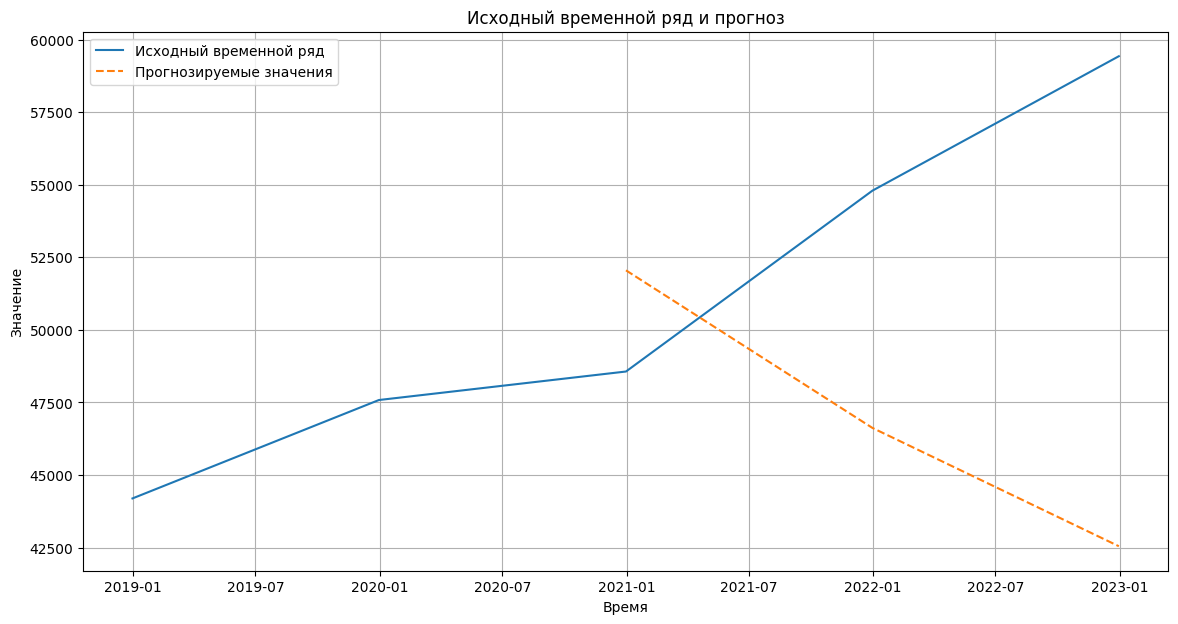

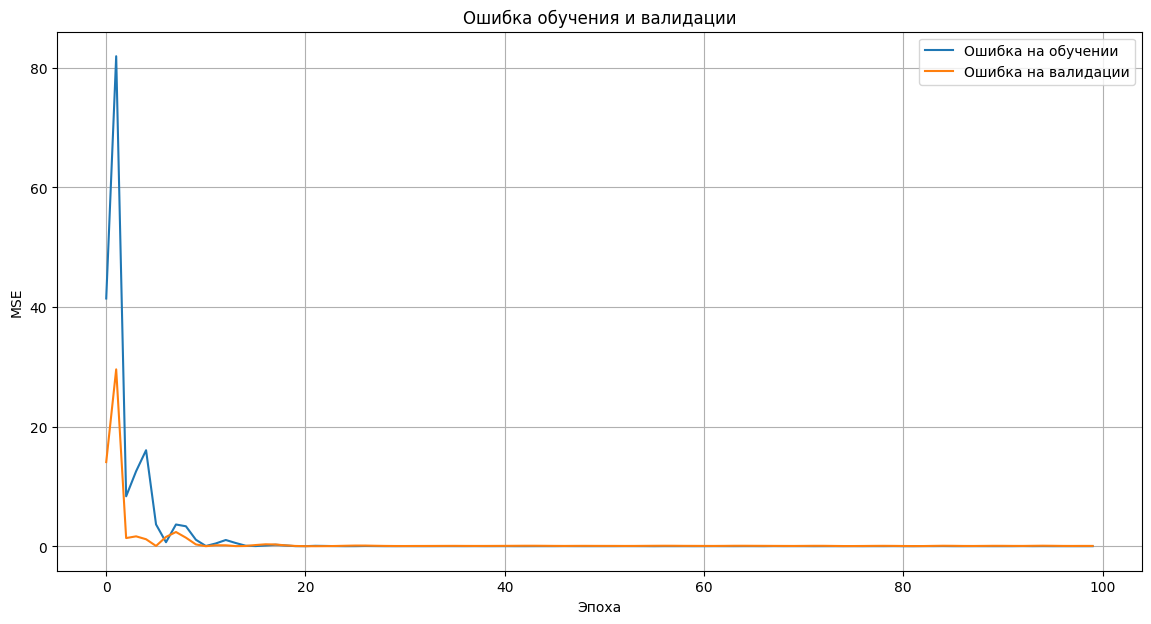

Пайплайн завершён.


In [ ]:
run_pipeline(df, "srd(cfo)", split_time=18, window_size=3,
                         batch_size=5, shuffle_buffer=5, epochs=100, future_steps=3)